## MNIST CNN (Keras + Tensorflow)

Comparison of Deep Shapley propagation with
- Gradient * Input
- Integrated Gradients
- DeepLIFT (Rescale and RevealCancel)
- Simple occlusion

### Get started
Assuming you have Keras > 2.2 and Tensorflow > 1.10, you will need the following libraries for comparison
- Install **DeepExplain**
https://github.com/marcoancona/DeepExplain
- Install **DeepLIFT**
https://github.com/kundajelab/deeplift
- Install **SHAP**
https://github.com/slundberg/shap

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os, pickle
sys.path.insert(0, os.path.abspath('../..'))
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D
from keras import regularizers
from keras import backend as K
import numpy as np
import tensorflow as tf
import scipy
print ("Using TF:", tf.__version__)
print ("Using Keras:", keras.__version__)



# Import DASP
from dasp import DASP, ImagePlayerIterator

#Import DeepLift
# Installation instructions: https://github.com/kundajelab/deeplift
import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.util import compile_func

# Import Deep Explain (for Grad * Input, Integrated Gradients and Occlusion implementations)
# Installation instructions: https://github.com/marcoancona/DeepExplain
from deepexplain.tensorflow import DeepExplain

Using TensorFlow backend.


Using TF: 1.11.0
Using Keras: 2.2.4


In [4]:
SKIP_TRAIN = False
saved_model_file = '.model_cifar.h5'
saved_model_weights_file = '.model_cifar_w.h5'

batch_size = 32
num_classes = 10
epochs = 10
data_augmentation = False
num_predictions = 20

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:], name='conv1'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), name='conv2'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', name='conv3'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), name='conv4'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, name='dense1'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, name='dense2'))
model.add(Activation('softmax'))



# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if SKIP_TRAIN:
    model = load_model(saved_model_file)
else:

    if not data_augmentation:
        print('Not using data augmentation.')
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True)
    else:
        print('Using real-time data augmentation.')
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=0.,  # set range for random shear
            zoom_range=0.,  # set range for random zoom
            channel_shift_range=0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)

        # Fit the model on the batches generated by datagen.flow().
        model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            workers=4)
    # Save model and weights
    model.save(saved_model_file)
    model.save_weights(saved_model_weights_file)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 17s 330us/step - loss: 1.7977 - acc: 0.3416 - val_loss: 1.5881 - val_acc: 0.4255
Epoch 2/10
50000/50000 [==============================] - 15s 299us/step - loss: 1.4875 - acc: 0.4609 - val_loss: 1.3266 - val_acc: 0.5201
Epoch 3/10
50000/50000 [==============================] - 15s 298us/step - loss: 1.3486 - acc: 0.5168 - val_loss: 1.2809 - val_acc: 0.5431
Epoch 4/10
50000/50000 [==============================] - 15s 300us/step - loss: 1.2520 - acc: 0.5526 - val_loss: 1.1289 - val_acc: 0.5983
Epoch 5/10
50000/50000 [==============================] - 15s 300us/step - loss: 1.1645 - acc: 0.5895 - val_loss: 1.0715 - val_acc: 0.6208
Epoch 6/10
50000/50000 [==============================] - 15s 298us/step - loss: 1.0993 - acc: 0.6126 - val_loss: 0.9919 - val_acc: 0.6545
Epoch 7/10
500

### Define a subset of the test set to generate explanations for

In [31]:
xs = x_test[0:20]
ys = y_test[0:20]
result_shape = xs.shape[:-1] + (1,)
a_gradin = np.zeros(result_shape)
a_intgrad = np.zeros(result_shape)
a_res =np.zeros(result_shape)
a_rc = np.zeros(result_shape)
a_occlusion = np.zeros(result_shape)
a_shap = np.zeros(result_shape)
a_sampling = np.zeros(result_shape)

### Use Deep Shapley propagation to compute approximate Shapley Values.
Notice that this requires to convert our original model into a propababilistic one. We provide probabilistic layers for this.
Also, this will require O(c*n) evaluations of the probabilistic network, where n is the number of input features and c is the number of coalition sizes to be tested (ideally c = n)

In [6]:
%%time
dasp = DASP(
    Model(model.inputs, model.layers[-2].output),
    player_generator=ImagePlayerIterator(xs, merge_channels=True)
)

1024
[(None, 32, 32, 3), (None, 32, 32, 3), (None, 1)]
Hello
linear
Tensor("conv1_1/stack:0", shape=(?, 32, 32, 32, 4), dtype=float32)
Tensor("input_4:0", shape=(?, 32, 32, 3, 2), dtype=float32)
Tensor("input_4:0", shape=(?, 32, 32, 3, 2), dtype=float32)
Tensor("activation_1_1/stack:0", shape=(?, 32, 32, 32, 2), dtype=float32)
Tensor("activation_1_1/stack:0", shape=(?, 32, 32, 32, 2), dtype=float32)
Tensor("max_pooling2d_1_1/stack_1:0", shape=(?, 15, 15, 32, 2), dtype=float32)
Tensor("max_pooling2d_1_1/stack_1:0", shape=(?, 15, 15, 32, 2), dtype=float32)
Tensor("activation_3_1/stack:0", shape=(?, 15, 15, 64, 2), dtype=float32)
Tensor("activation_3_1/stack:0", shape=(?, 15, 15, 64, 2), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3, 2)      0         
_________________________________________________________________
conv1 (LPConv2D)           

In [ ]:
%%time
# Load or...
# r = pickle.load( open( "data/cifar10_DASP_convergence.pkl", "rb" ) )
# #a_shap = r.mean(1).reshape(-1, 32, 32)
# print (r.shape)

dasps = []
kns = [1, 2, 4, 8, 16, 32, 64, 128]
for xn in kns:
    s = dasp.run(xs, xn)
    print (s.shape)
    s = np.array([s[i, c, :] for i, c in enumerate(np.argmax(ys, 1))])
    dasps.append((xn, s))

[512]
(20, 10, 32, 32, 1)
[256, 768]


In [ ]:
a_shap = dasps[-1][1]
with open('.cifar10_dasps.pkl', 'wb') as f:
    pickle.dump(dasps, f)

In [27]:
print (a_shap)

[[[[ 0.00078633]
   [-0.00130567]
   [-0.00429058]
   ...
   [-0.00097322]
   [-0.00118137]
   [-0.00068644]]

  [[ 0.00031304]
   [-0.00536449]
   [-0.00728732]
   ...
   [-0.00038806]
   [-0.00204134]
   [-0.00091318]]

  [[ 0.00160481]
   [-0.00238687]
   [-0.003439  ]
   ...
   [ 0.00133881]
   [ 0.00060756]
   [ 0.0001434 ]]

  ...

  [[-0.01001264]
   [-0.00893645]
   [ 0.00490252]
   ...
   [ 0.00289266]
   [-0.0018294 ]
   [-0.00402126]]

  [[-0.00610992]
   [-0.00441871]
   [ 0.00221712]
   ...
   [ 0.00299379]
   [-0.00199889]
   [-0.0008995 ]]

  [[-0.00200994]
   [-0.00174734]
   [-0.00061097]
   ...
   [ 0.00198609]
   [-0.00110348]
   [-0.00023769]]]


 [[[ 0.00337123]
   [-0.00068764]
   [-0.00550243]
   ...
   [-0.00156523]
   [-0.00126577]
   [ 0.00083495]]

  [[ 0.00599862]
   [-0.01709622]
   [-0.01792582]
   ...
   [-0.00077544]
   [-0.00150437]
   [ 0.00333933]]

  [[ 0.00409123]
   [-0.01687089]
   [-0.00625304]
   ...
   [ 0.00348317]
   [ 0.00207099]
   [ 0.0063

In [9]:
# Comparison first hidden layer distributions
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.mlab as mlab

idx = 1
unit_idx = 300
k = 500


testmodel = Sequential()
testmodel.add(Conv2D(32, (3, 3), padding='valid', input_shape=x_train.shape[1:], name='conv1'))
testmodel.load_weights(saved_model_weights_file, by_name=True)


# Create an equivalent probabilistic model.
probInputTest = Input(shape=xs.shape[1:])
playerMaskTest = Input(shape=xs.shape[1:])
coalitionSizeTest = Input(shape=(1,))

y = ProbConv2DInput(32, (3, 3), padding='valid', input_shape=x_train.shape[1:], name='conv1')([probInputTest, playerMaskTest, coalitionSizeTest])
probModelTest = Model(inputs=[probInputTest, playerMaskTest, coalitionSizeTest], outputs=y)
probModelTest.load_weights(saved_model_weights_file, by_name=True)

results = []
for i in range(10000):
    x = xs[idx:idx+1].reshape(1, 32, 32, 3)
    p = np.random.permutation(32*32)
    m = np.zeros_like(x)
    #print (np.unravel_index(p[:k], (32, 32, 3)))
    #print ( m[np.unravel_index(p[:k], (1, 32, 32, 3))].shape)
    indices = np.unravel_index(p[:k], (1, 32, 32))
    m[indices + (0,)] = 1
    if i < 2:
        print (np.sum(m))
    y = testmodel.predict((x*m).reshape(1, 32, 32, 3))
    results.append(y.flatten()[unit_idx])
    
# Workaround: Keras does not seem to support scalar inputs
_k = np.array([[k]]*len(x))
mask = np.ones_like(x).reshape(1, 32, 32, 3)
mask[:, 0, 0, 0] = 0
Y = probModelTest.predict([x.reshape(1, 32, 32, 3), mask, _k])
Y = Y.reshape(-1, 4)[unit_idx]
mu, var = Y[0], Y[1]
print (mu, var)
print ("Stats")
print (np.mean(results), np.var(results))
sigma = var**0.5

plt.hist(results, bins=10, density=True)
hist = np.histogram(results, bins=10)
hist_dist = scipy.stats.rv_histogram(hist)

_x = np.linspace(mu - 3*sigma, mu + 3*sigma, 400, )
plt.plot(_x, hist_dist.pdf(_x), label='PDF')
plt.plot(_x, mlab.normpdf(_x, mu, sigma))

NameError: name 'ProbConv2DInput' is not defined

### Use DeepExplain framework to compute attributions using Gradient * Input, Integrated Gradients and Occlusion
Occlusion is performed by replacing one pixel at the time with a zero value and measuring the difference in the target output caused by such occlusion.

In [ ]:
%%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    a_gradin = de.explain('grad*input', target_tensor * ys, input_tensor, xs)
    a_intgrad = de.explain('intgrad', target_tensor * ys, input_tensor, xs)
    intgrads = [(k, de.explain('intgrad', target_tensor * ys, input_tensor, xs, steps=k).sum(-1)) for k in [1, 2, 4, 8, 16, 32, 64, 128]]
    a_occlusion = de.explain('occlusion', target_tensor * ys, input_tensor, xs, window_shape=(1, 1, 3))
    print ("Done")
a_intgrad = np.sum(a_intgrad, -1)
a_occlusion = np.sum(a_occlusion, -1)

### Use DeepLIFT framework to compute attributions according to both Rescale and RevealCancel methods

In [ ]:
%%time
# Compute DeepLift attributions
revealcancel_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)

    
    
rescale_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.Rescale)

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
rescale_func = rescale_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

a_rc = np.array([np.array(revealcancel_func(
                task_idx=np.argmax(y),
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x, y in zip(xs,ys)])

a_res = np.array([np.array(rescale_func(
                task_idx=np.argmax(y),
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x, y in zip(xs,ys)])

a_rc = a_rc[:, 0, ...].sum(-1)
a_res = a_res[:, 0, ...].sum(-1)

In [ ]:
a_rc = a_rc.sum(-1)
a_res = a_res.sum(-1)

In [ ]:
import shap

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer((model.layers[0].input, model.layers[-2].output), background)
shap_values = e.shap_values(xs)
#shap.image_plot(shap_values, -xs)
a_shaplud = [shap_values[idx][i] for i, idx in enumerate(np.argmax(ys, 1))]


In [ ]:
%%time
np.random.seed(14123)
from utils.shapley_sampling import run_shapley_sampling
samplings = []
def callback(snapshot):
    print (snapshot[0])
    samplings.append((snapshot[0], snapshot[1]))

def run_sampling(runs):
    return run_shapley_sampling(fModel, xs, ys, runs=runs, feat_dims=[1,2], callback=callback)
a_sampling = run_sampling(2**13)
print (a_sampling.shape)

with open('.cifar10_sampling.pkl', 'wb') as f:
    pickle.dump(a_sampling, f)
with open('.cifar10_sampling_convergence.pkl', 'wb') as f:
    pickle.dump(samplings, f)

    
# a_sampling = pickle.load( open( "data/cifar10_sampling2.pkl", "rb" ) )
# samplings = pickle.load( open( "data/cifar10_sampling_convergence.pkl", "rb" ) )

Data shape:  [20, 32, 32, 3]
Runs 8192
Shape to mask features:  [20, -1, 3]
1
2
4
8


In [43]:
attributions = [
    ('Integrated\nGradients',      a_intgrad), 
    ('DeepLIFT\n(Rescale)',        a_res), 
    ('DeepLIFT\n(RevCancel)',      a_rc), 
    ('Occlusion',                  a_occlusion), 
    ('DASP (Ours)',                a_shap), 
    ('Sampling',                   a_sampling)
]
for a in attributions:
    print (a[1].shape)

# with open('data/cifar10_attributions.pkl', 'wb') as f:
#       pickle.dump(attributions, f)
# or load:

# attributions = pickle.load( open( "data/cifar10_attributions.pkl", "rb" ) )
# attributions[4] = ('DASP (Ours)*',                       a_shap)

(20, 32, 32)
(20, 32, 32)
(20, 32, 32)
(20, 32, 32)
(20, 32, 32, 1)
(20, 32, 32)


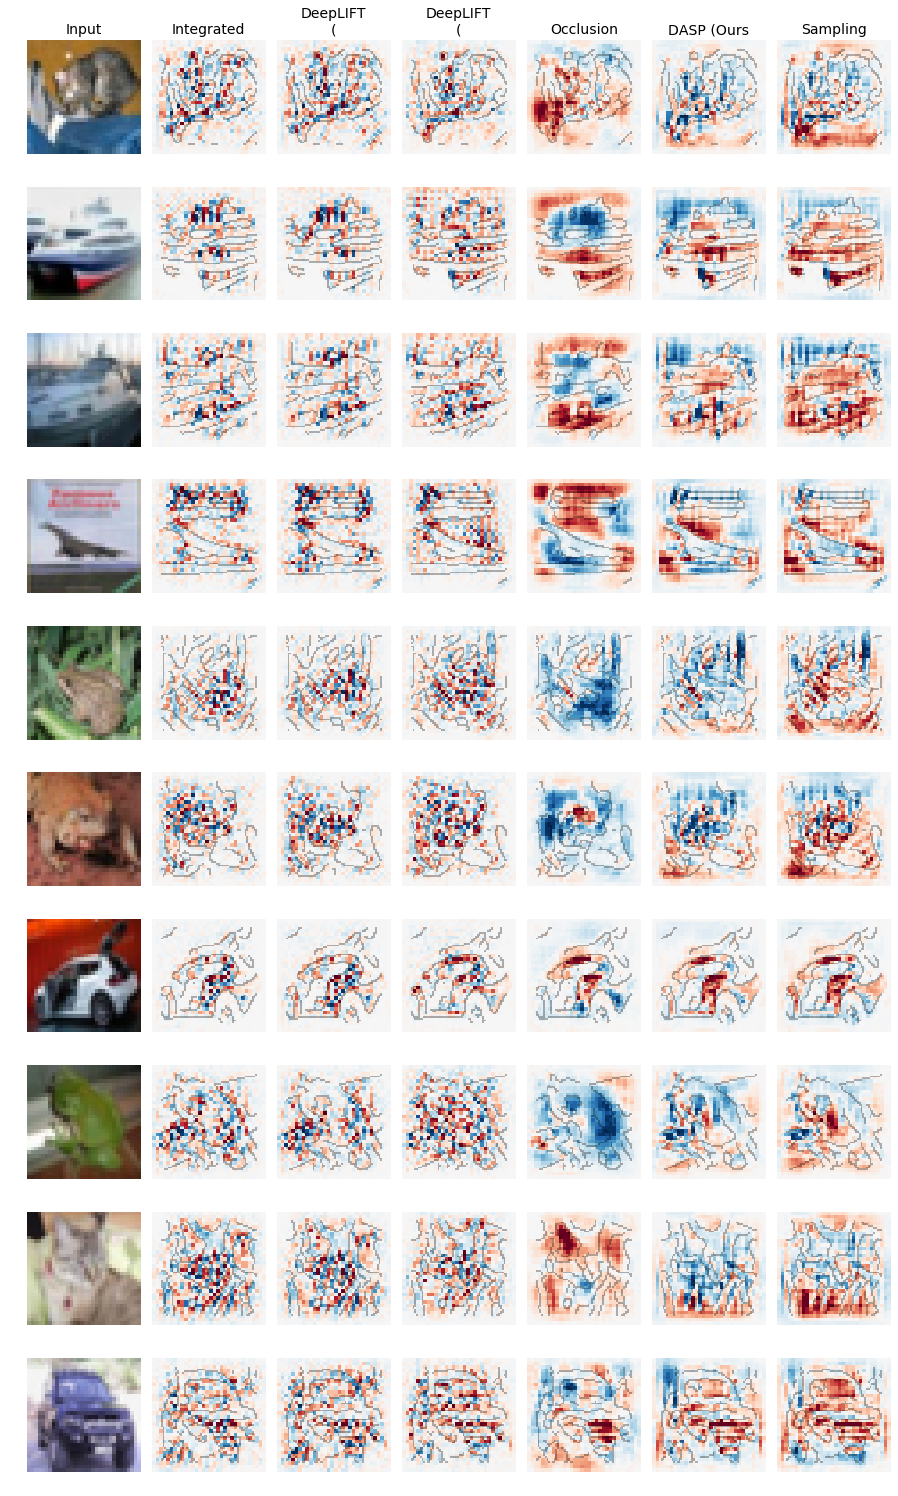

In [44]:
# Plot attributions
%matplotlib inline
from utils.utils import plot_attribution_maps

# Plot all
plot_attribution_maps("cifar10", 
                      xs, 
                      [x[1][:10] for x in attributions],
                      [x[0][:10] for x in attributions],
                      percentile=99,
                      show_original=True,
                      dilation=2,
                      alpha=0.3,
                      )

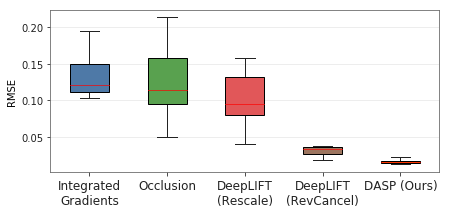

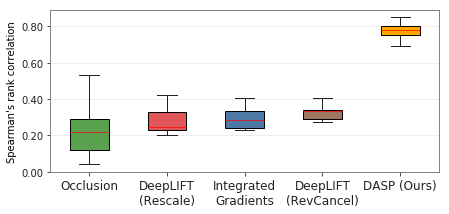

In [46]:
from utils.utils import plot_mse_comparison, plot_kendall_comparison


plot_mse_comparison('cifar10',
                    [x[1][:10] for x in attributions],
                    [x[0] for x in attributions],
                    gt_idx=-1)
plot_kendall_comparison('cifar10',
                        [x[1][:10] for x in attributions],
                        [x[0] for x in attributions],
                        gt_idx=-1)

Running robustness test...


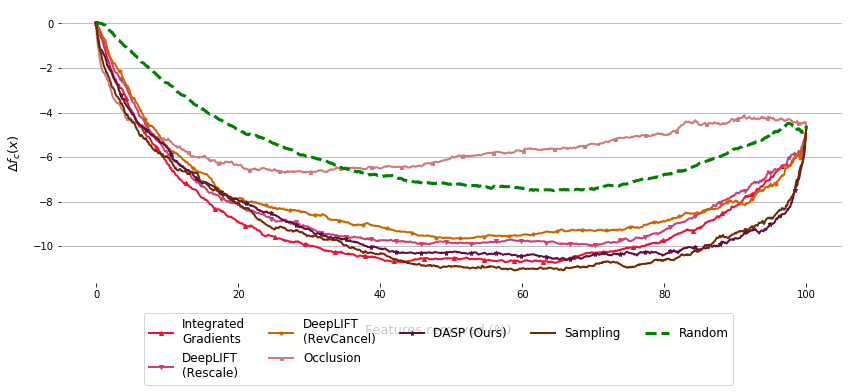

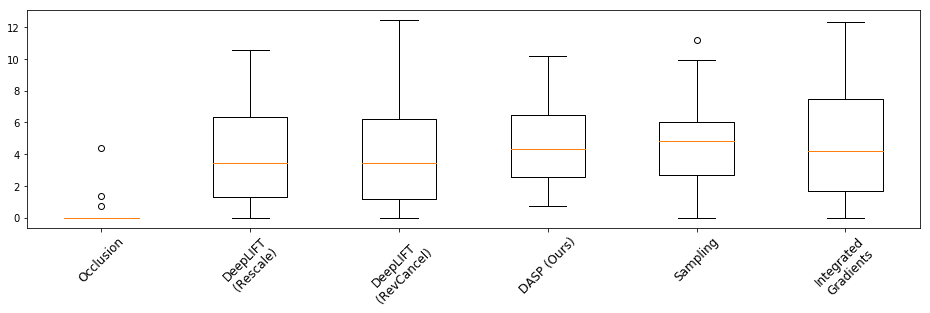

In [47]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from utils.accuracy_robustness import run_robustness_test
init_notebook_mode(connected=True)

run_robustness_test(fModel, xs, ys,  [x[1][:,:,:,None] for x in attributions], [x[0] for x in attributions], 'mnist_cnn', 1,
                        result_path='.', mode='prediction', reduce_dim=None)

### Run Deep Shapley with different values of kn and measure how fast it converges

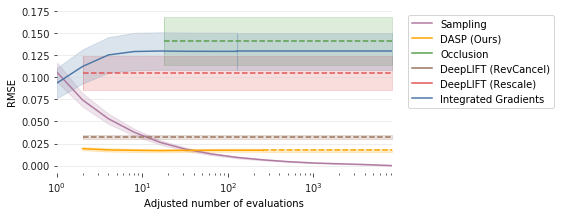

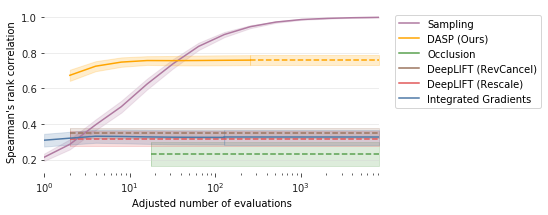

In [48]:
from utils.convergence_plot import convergence_comparison_rmse, convergence_comparison_corr
_samplings_y = [x[1] for x in samplings]
_samplings_x = [x[0] for x in samplings]
_dasps_y = [x[1] for x in dasps]
_dasps_x = [x[0] for x in dasps]
_intgrad_y = [x[1] for x in intgrads]
_intgrad_x = [x[0] for x in intgrads]
ticks = [_samplings_x, [2*x for x in _dasps_x], [18], [2], [2], _intgrad_x]
names = ['Sampling', 'DASP (Ours)', 'Occlusion', 'DeepLIFT (RevCancel)', 'DeepLIFT (Rescale)', 'Integrated Gradients']
data = [_samplings_y, _dasps_y, [a_occlusion], [a_rc], [a_res], _intgrad_y]

convergence_comparison_rmse('cifar10', data, names, ticks, a_sampling)
convergence_comparison_corr('cifar10', data, names, ticks, a_sampling)